# Error mitigation technique explanations

This page provides high-level explanations of the error suppression and error mitigation techniques available through Qiskit Runtime.

The following cell imports the Estimator primitive and creates a backend that will be used for initializing the Estimator in later code cells.

In [1]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy()

## Dynamical decoupling

Quantum circuits are executed on IBM hardware as sequences of microwave pulses that need to be scheduled and run at precise time intervals.
Unfortunately, unwanted interactions between qubits can lead to coherent errors on idling qubits. Dynamical decoupling works by inserting pulse sequences on idling qubits to approximately cancel out the effect of these errors. Each inserted pulse sequence amounts to an identity operation, but the physical presence of the pulses has the effect of suppressing errors.
There are many possible cohoice of pulse sequences, and which sequence is better for each particular case remains an [active area of research](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.20.064027).

The diagram below depicts dynamical decoupling with an XX pulse sequence. The abstract circuit on the left is mapped onto a microwave pulse schedule on the top right. The bottom right depicts the same schedule, but with a sequence of two X pulses inserted during an idle period of the first qubit.

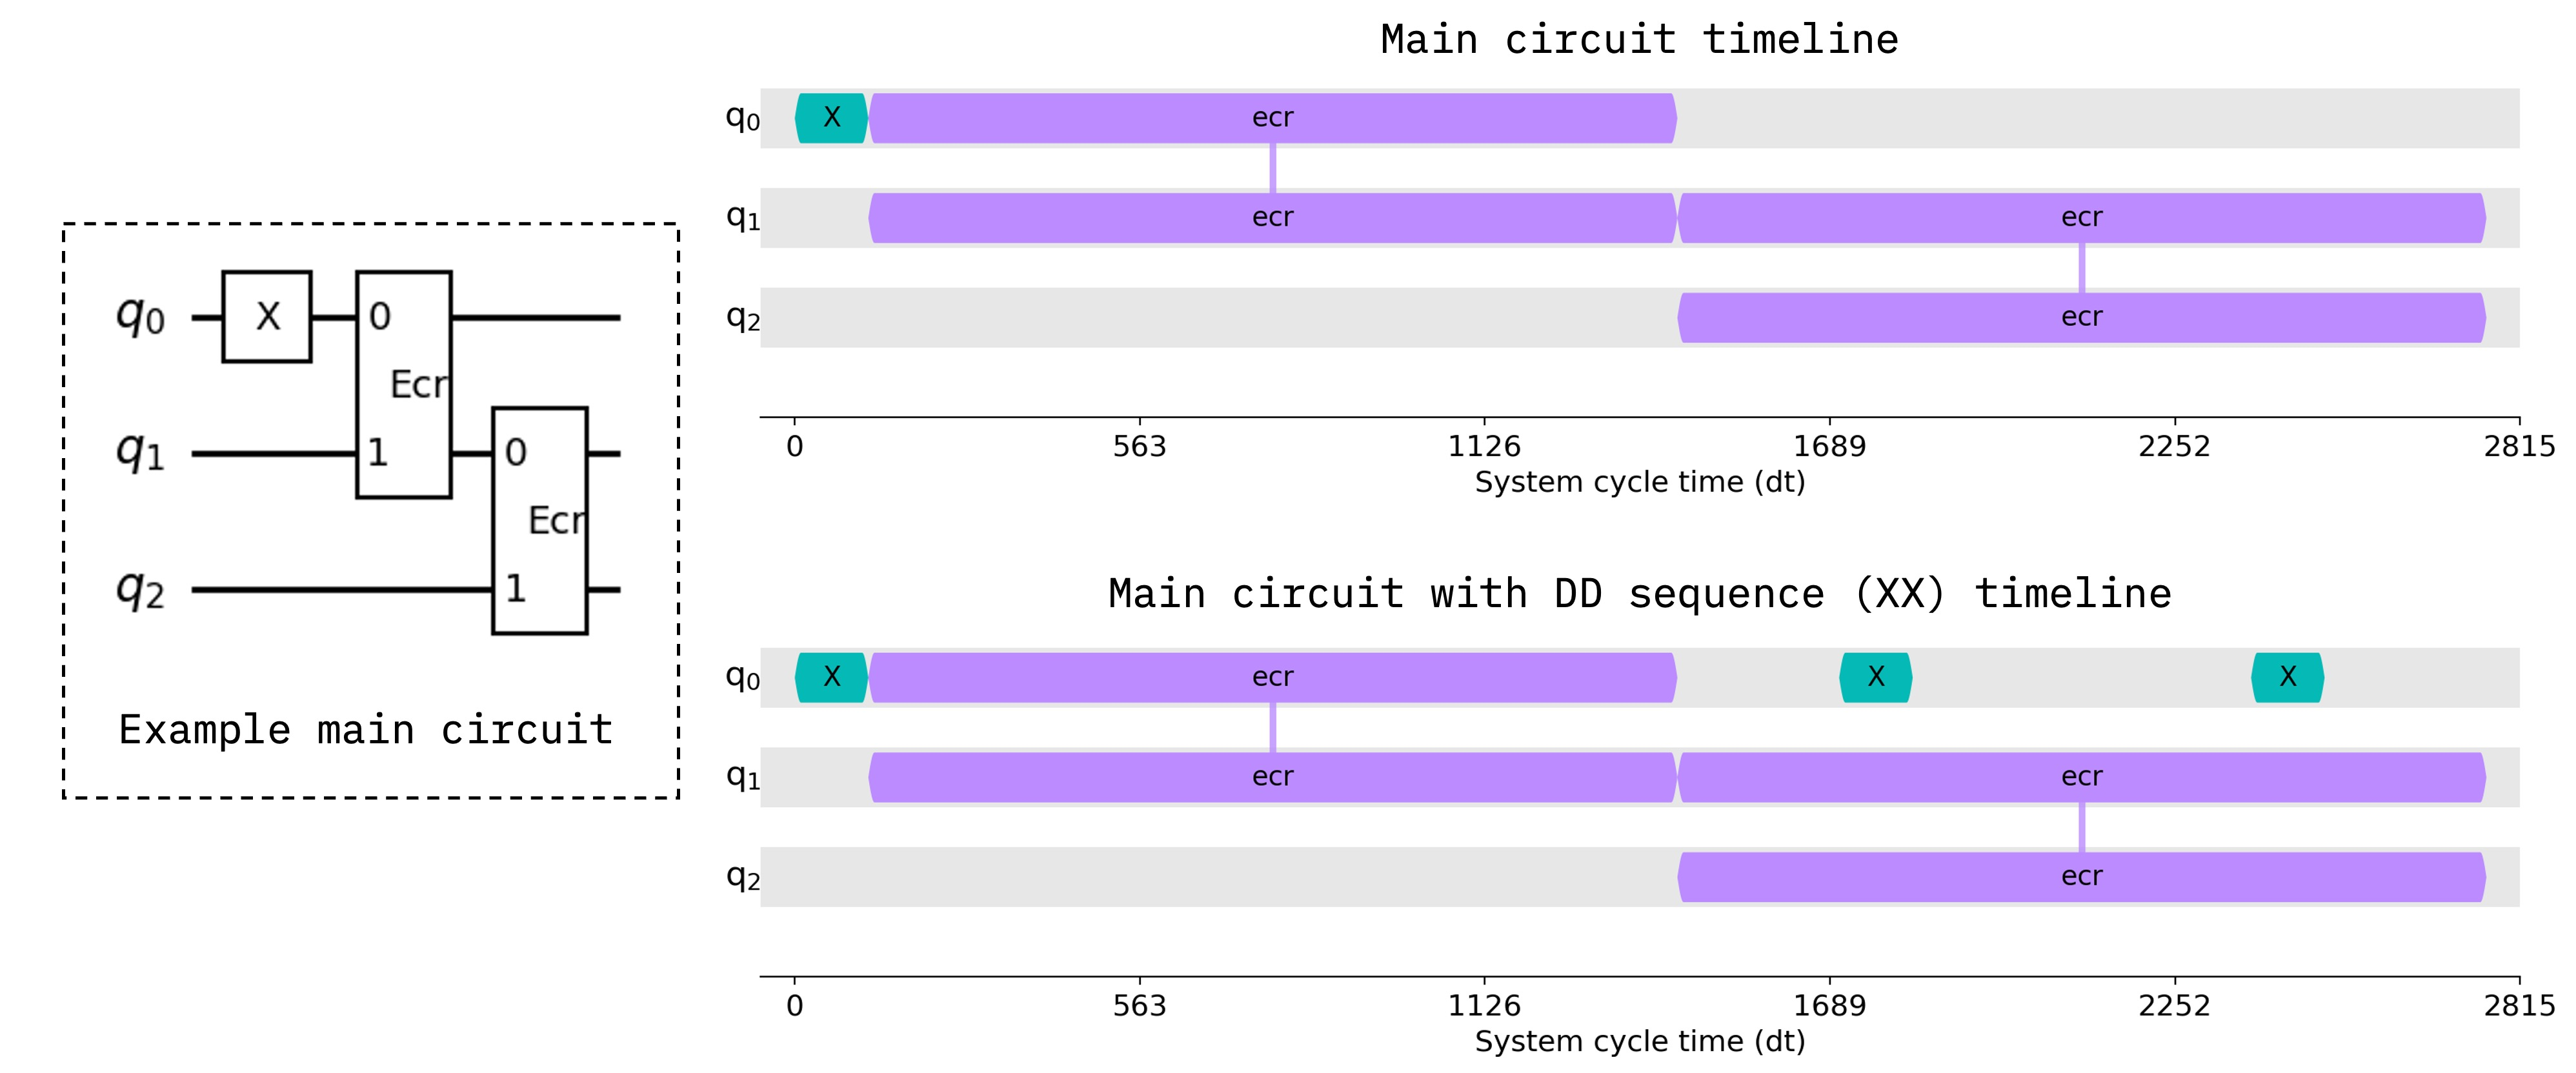

The Qiskit Runtime options for dynamical decoupling are described [here](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions). Notably, the `sequence_type` option can be used to pick from several different pulse sequences.

The following code cell shows how to enable dynamical decoupling for the estimator and choose a dynamical decoupling sequence.

In [2]:
estimator = Estimator(backend=backend)
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XpXm"

## Pauli twirling

Twirling, also known as [randomized compiling](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.94.052325), is a widely used technique for converting arbitrary noise channels into noise channels with more specific structure.

Pauli twirling is a special kind of twirling that uses Pauli operations. It has the effect of transforming any quantum channel into a Pauli channel. Performed alone, it can mitigate coherent noise because coherent noise tends to accumulate quadratically with the number of operations, whereas Pauli noise accumulates linearly. Pauli twirling is often combined with other error mitigation techniques that work better with Pauli noise than with arbitrary noise.

Pauli twirling is implemented by sandwiching a chosen set of gates with randomly chosen single-qubit Pauli gates in such a way that the ideal effect of the gate remains the same. The result is that a single circuit is replaced with a random ensemble of circuits, all with the same ideal effect. When sampling the circuit, samples are drawn from multiple random instances, rather than just a single one.

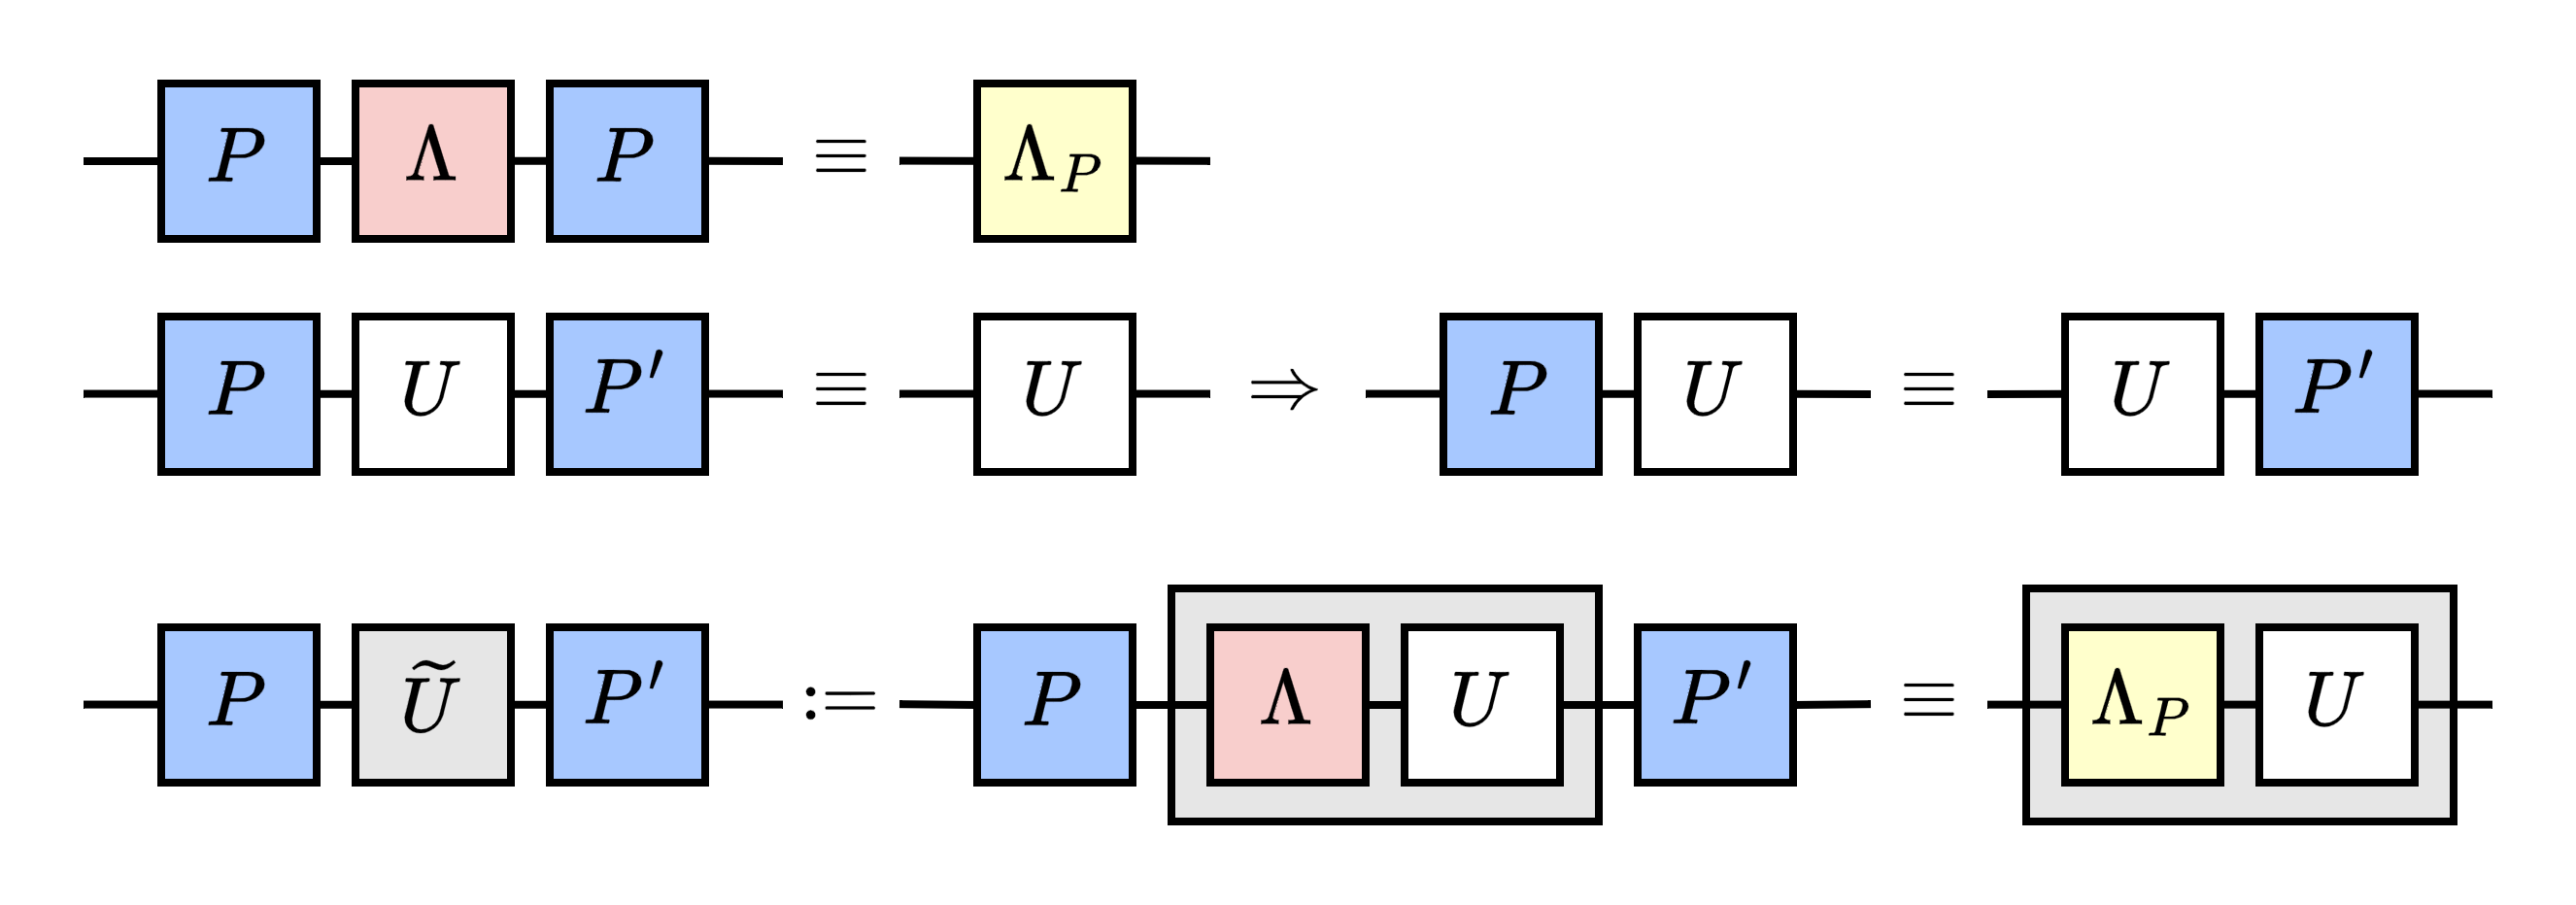

Since most of the errors in current quantum hardware come from two-qubit gates, this technique is often applied exclusively to (native) two-qubit gates. The following diagram depicts some Pauli twirls for the CNOT and ECR gates. Every circuit within a row has the same ideal effect.

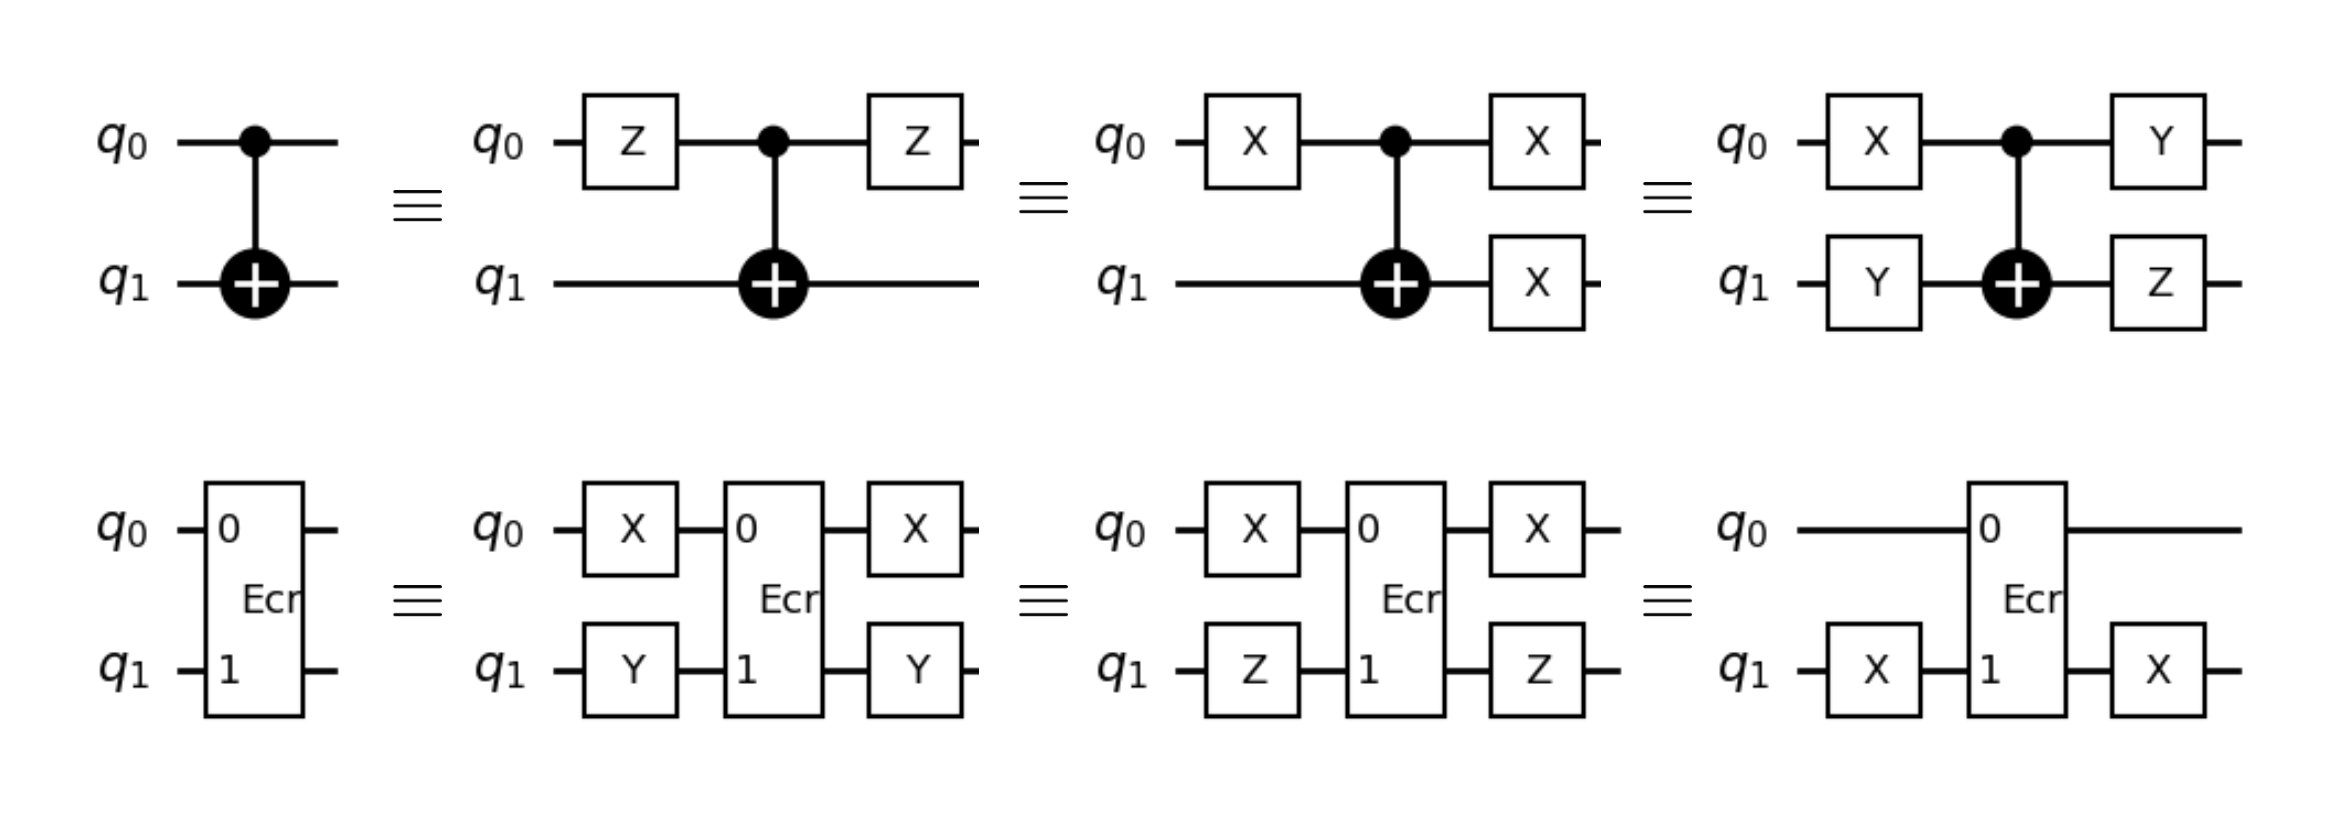

The Qiskit Runtime options for Pauli twirling are described [here](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions). The following options are notable:

- `enable_gates`: Set this to `True` to enable Pauli twirling of two-qubit gates.
- `num_randomizations`: The number of circuit instances to draw from the ensemble of twirled circuits.
- `shots_per_randomization`: The number of shots to sample from each circuit instance.

The following code cell shows how to enable Pauli twirling and set these options for the estimator.

In [3]:
estimator = Estimator(backend=backend)
estimator.options.twirling.enable_gates = True
estimator.options.twirling.num_randomizations = 32
estimator.options.twirling.shots_per_randomization = 100

## Twirled readout error extinction (TREX)

[Twirled readout error extinction (TREX)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032620) mitigates the effect of measurement errors for the estimation of Pauli observable expectation values.
 It is based on the notion of twirled measurements, which are accomplished by randomly substituting measurement gates by a sequence of (1) a Pauli X gate, (2) a measurement, and (3) classical bit flip. Just like in standard gate twirling, this sequence is equivalent to a plain measurement in the absence of noise, as depicted in the following diagram:

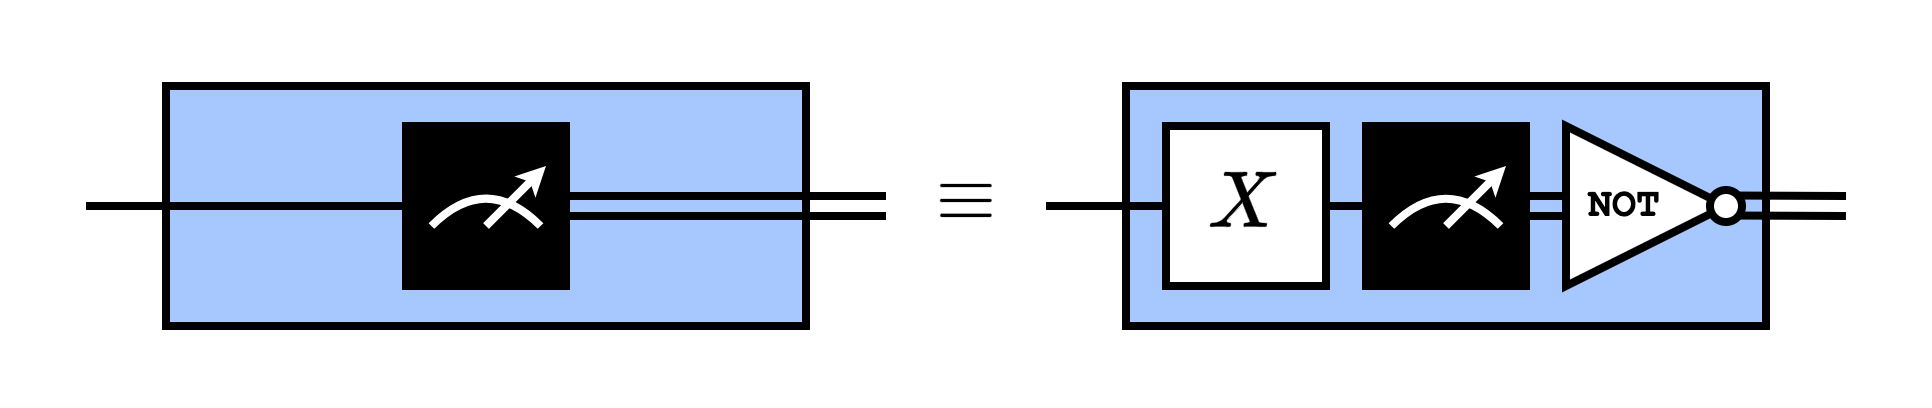

In the presence of readout error, measurement twirling has the effect of diagonalizing the readout-error transfer matrix, making it easy to invert. Estimating the readout-error transfer matrix requires executing additional calibration circuits, which introduces a small overhead.

TREX can be enabled by setting `measure_mitigation` to `True` in version 2 of the [Qiskit Runtime resilience options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2). Options for measurement twirling are described [here](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.MeasureNoiseLearningOptions). As in gate twirling, you can set the number of circuit randomizations and the number of shots per randomization.

The following code cell shows how to enable TREX and set these options for the estimator.

In [4]:
estimator = Estimator(backend=backend)
estimator.options.resilience.measure_mitigation = True
estimator.options.resilience.measure_noise_learning.num_randomizations = 32
estimator.options.resilience.measure_noise_learning.shots_per_randomization = 100

## Zero-noise extrapolation (ZNE)

Zero-noise extrapolation (ZNE) is a technique for mitigating errors in estimating expectation values of observables. While it often improves results, it is not guaranteed to produce an unbiased result.

ZNE consists of two stages:

1. _Noise amplification_: The original quantum circuit is executed multiple times at different noise rates.
2. _Extrapolation_: The ideal result is estimated by extrapolating the noisy expectation value results to the zero-noise limit.

Both the noise amplification and extrapolation stages can be implemented in many different ways. Qiskit Runtime implements noise amplification by "digital gate folding," which means that two-qubit gates are replaced with equivalent sequences of the gate and its inverse. For example, replacing a unitary $U$ with $U U^\dagger U$ would yield a noise amplification factor of 3. For the extrapolation, you can choose from one of several functional forms, including a linear fit or an exponential fit.
The image below depicts digital gate folding on the left, and the extrapolation procedure on the right.

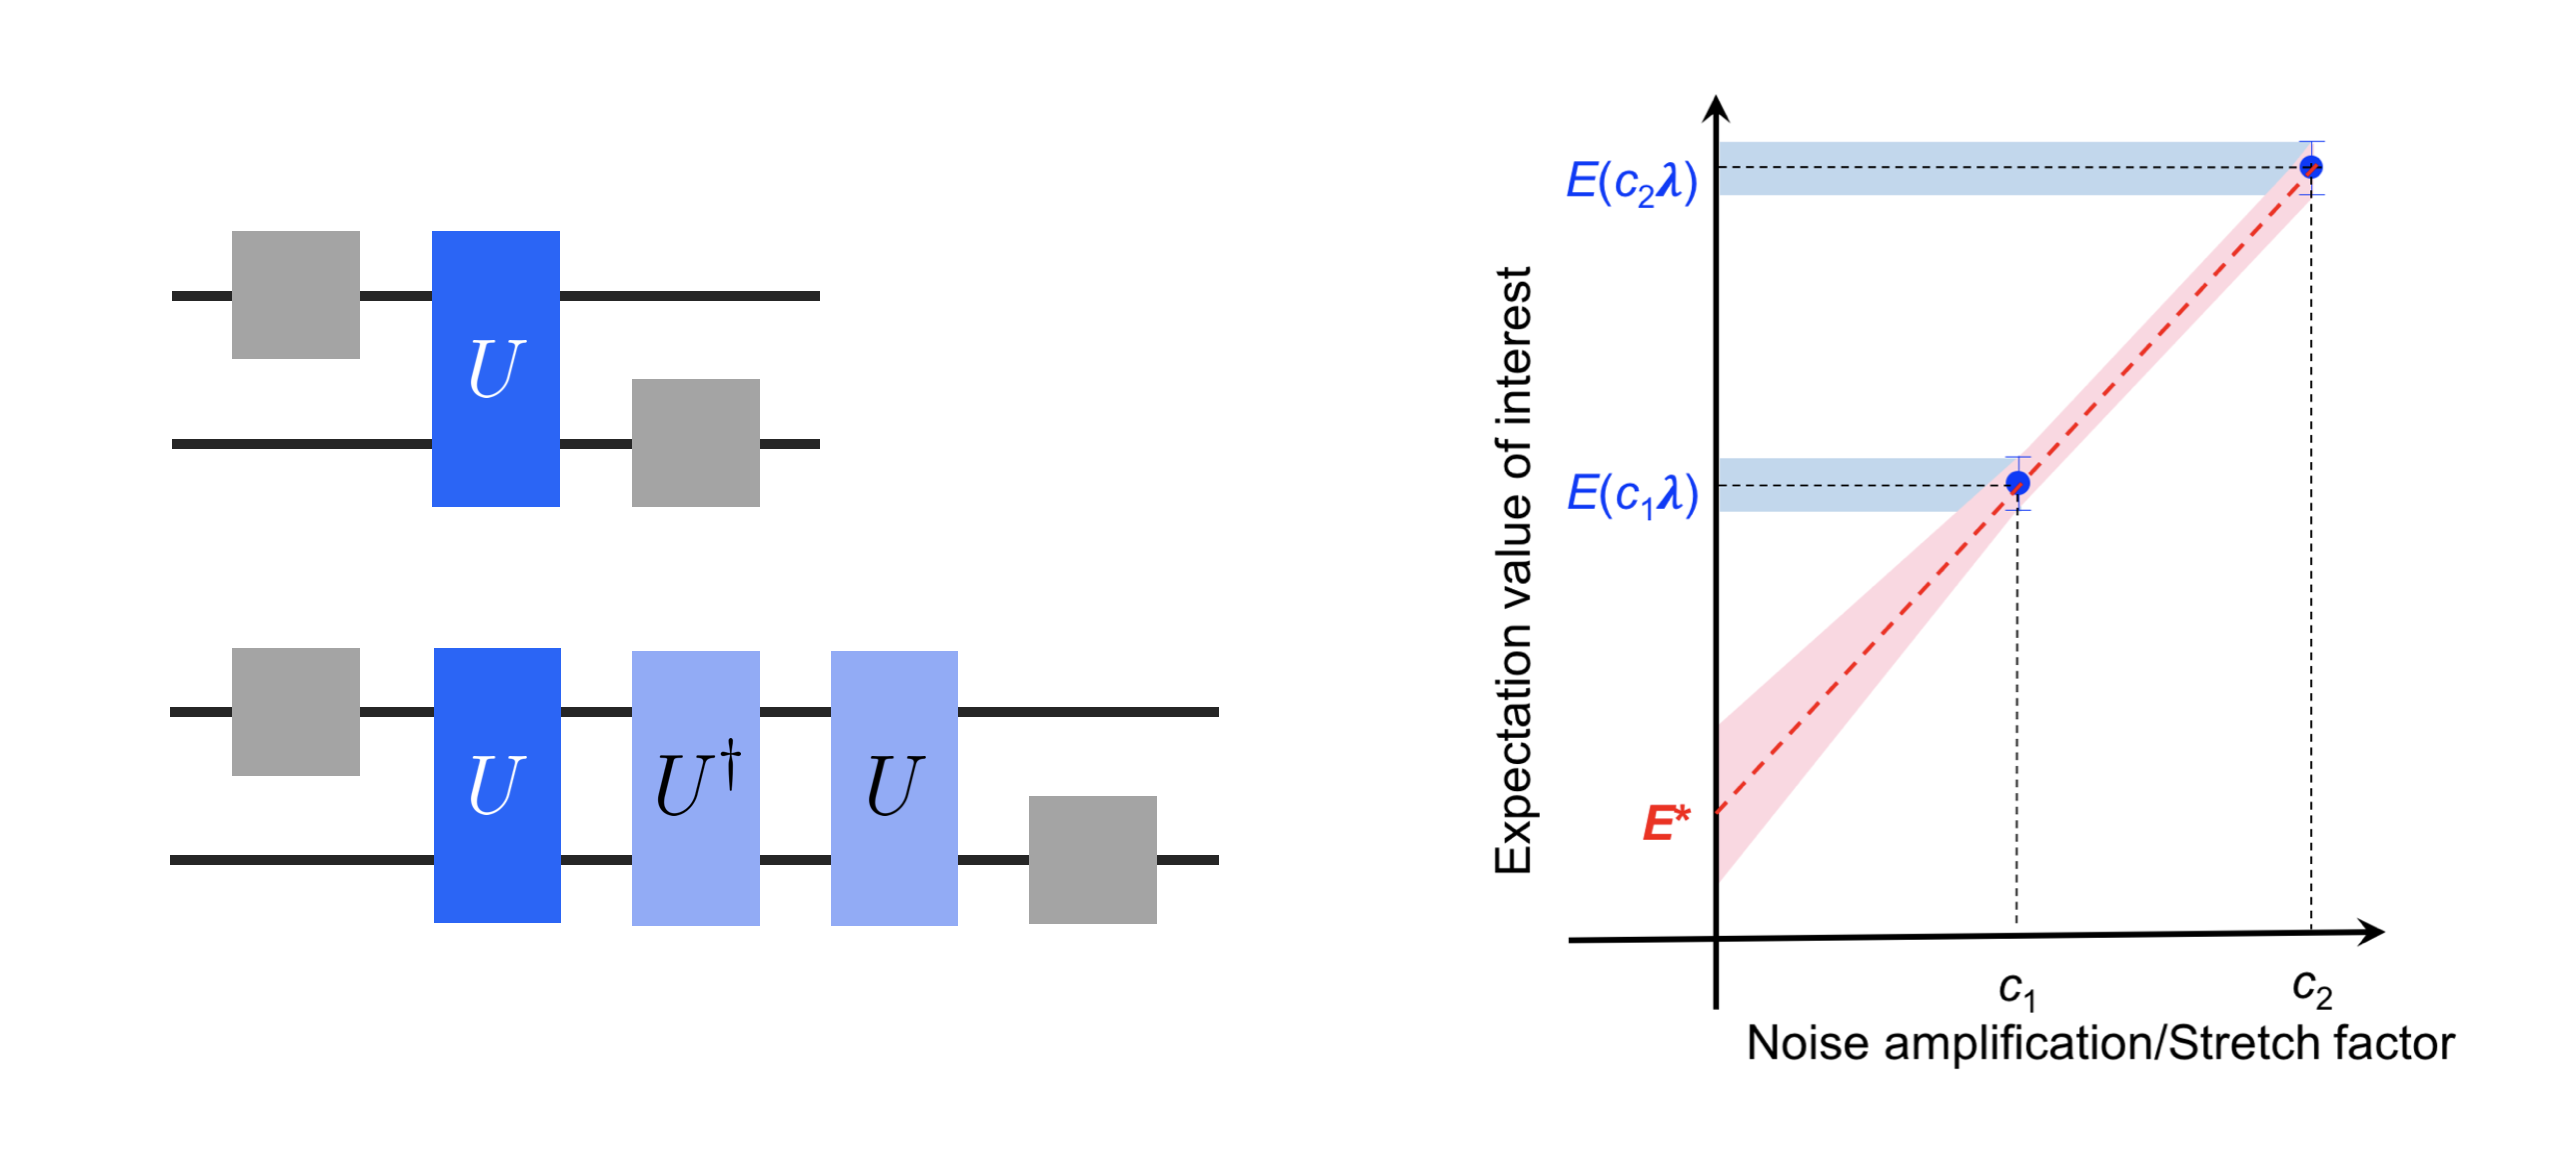

ZNE can be enabled by setting `zne_mitigation` to `True` in version 2 of the [Qiskit Runtime resilience options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2).
The Qiskit Runtime options for ZNE are described [here](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions). The following options are notable:

- `noise_factors`: The noise factors to use for noise amplification.
- `extrapolator`: The functional form to use for the extrapolation.

The following code cell shows how enable ZNE and set these options for the estimator.

In [5]:
estimator = Estimator(backend=backend)
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = (1, 3, 5)
estimator.options.resilience.zne.extrapolator = "exponential"

## Probabilistic error cancellation (PEC)

Probabilistic error cancellation (PEC) is a technique for mitigating errors in estimating expectation values of observables. Unlike ZNE, it returns an unbiased estimate of the expectation value. However, it generally incurs a greater overhead.

In PEC, the effect of an ideal target circuit is expressed as a linear combination of noisy circuits that are actually implementable in practice:

$$
\mathcal{U}_{\text{ideal}} = \sum_{i} \eta_i U_{noisy, i}
$$

The output of the ideal circuit can then be reproduced by executing different noisy circuit instances drawn from a random ensemble defined by the linear combination. If the coefficients $\eta_i$ form a probability distribution, they can be used directly as the probabilities of the ensemble. In practice, some of the coefficients are negative, so they form a quasiprobability distribution instead. They can still be used to define a random ensemble, but there is a sampling overhead related to the negativity of the quasiprobability distribution, which is characterized by the quantity

$$
\gamma = \sum_{i} \lvert \eta_i \rvert \geq 1.
$$

The sampling overhead is a multiplicative factor on the number of shots required to estimate an expectation value to a given precision, compared to the number of shots that would be needed from the ideal circuit. It scales quadratically with $\gamma$, which in turn scales exponentially with the depth of the circuit.

ZNE can be enabled by setting `pec_mitigation` to `True` in version 2 of the [Qiskit Runtime resilience options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2).
The Qiskit Runtime options for PEC are described [here](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.PecOptions). A limit on the sampling overhead can be set using the `max_overhead` option. Note that limiting the sampling overhead can cause the precision of the result to exceed the requested precision. The default value of `max_overhead` is 100.

The following code cell shows how to enable PEC and set the `max_overhead` option for the estimator.

In [6]:
estimator = Estimator(backend=backend)
estimator.options.resilience.pec_mitigation = True
estimator.options.resilience.pec.max_overhead = 100